In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [2]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device is mps
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

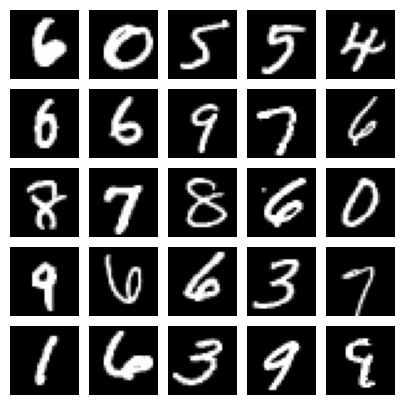

In [3]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [ ]:
from vae import VAE, loss_function
from torch.optim import Adam

model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

def train(model, optimizer, epochs, x_dim, train_loader, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(-1, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var, alpha=0.5)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss


In [5]:
train(model, optimizer, epochs=50, x_dim=784, train_loader=train_loader, device=device)

	Epoch 1 	Average Loss:  18.670631958888126
	Epoch 2 	Average Loss:  16.421674648920696
	Epoch 3 	Average Loss:  15.956100897911268
	Epoch 4 	Average Loss:  15.660664191612831
	Epoch 5 	Average Loss:  15.371907733444475
	Epoch 6 	Average Loss:  15.172889022745638
	Epoch 7 	Average Loss:  15.019571504022322
	Epoch 8 	Average Loss:  14.926950381352352
	Epoch 9 	Average Loss:  14.821815539629032
	Epoch 10 	Average Loss:  14.745763383359991
	Epoch 11 	Average Loss:  14.689801933418991
	Epoch 12 	Average Loss:  14.606838908969847
	Epoch 13 	Average Loss:  14.559639659702269
	Epoch 14 	Average Loss:  14.494353722303341
	Epoch 15 	Average Loss:  14.462723760523348
	Epoch 16 	Average Loss:  14.419865267908472
	Epoch 17 	Average Loss:  14.365270577944242
	Epoch 18 	Average Loss:  14.32526836436019
	Epoch 19 	Average Loss:  14.302295890628782
	Epoch 20 	Average Loss:  14.251968854512924
	Epoch 21 	Average Loss:  14.226156691200712
	Epoch 22 	Average Loss:  14.186178207397461
	Epoch 23 	Average L

818038.3721923828

In [6]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

# generate_digit(1.0, 1.0), generate_digit(1.0, 0.0)

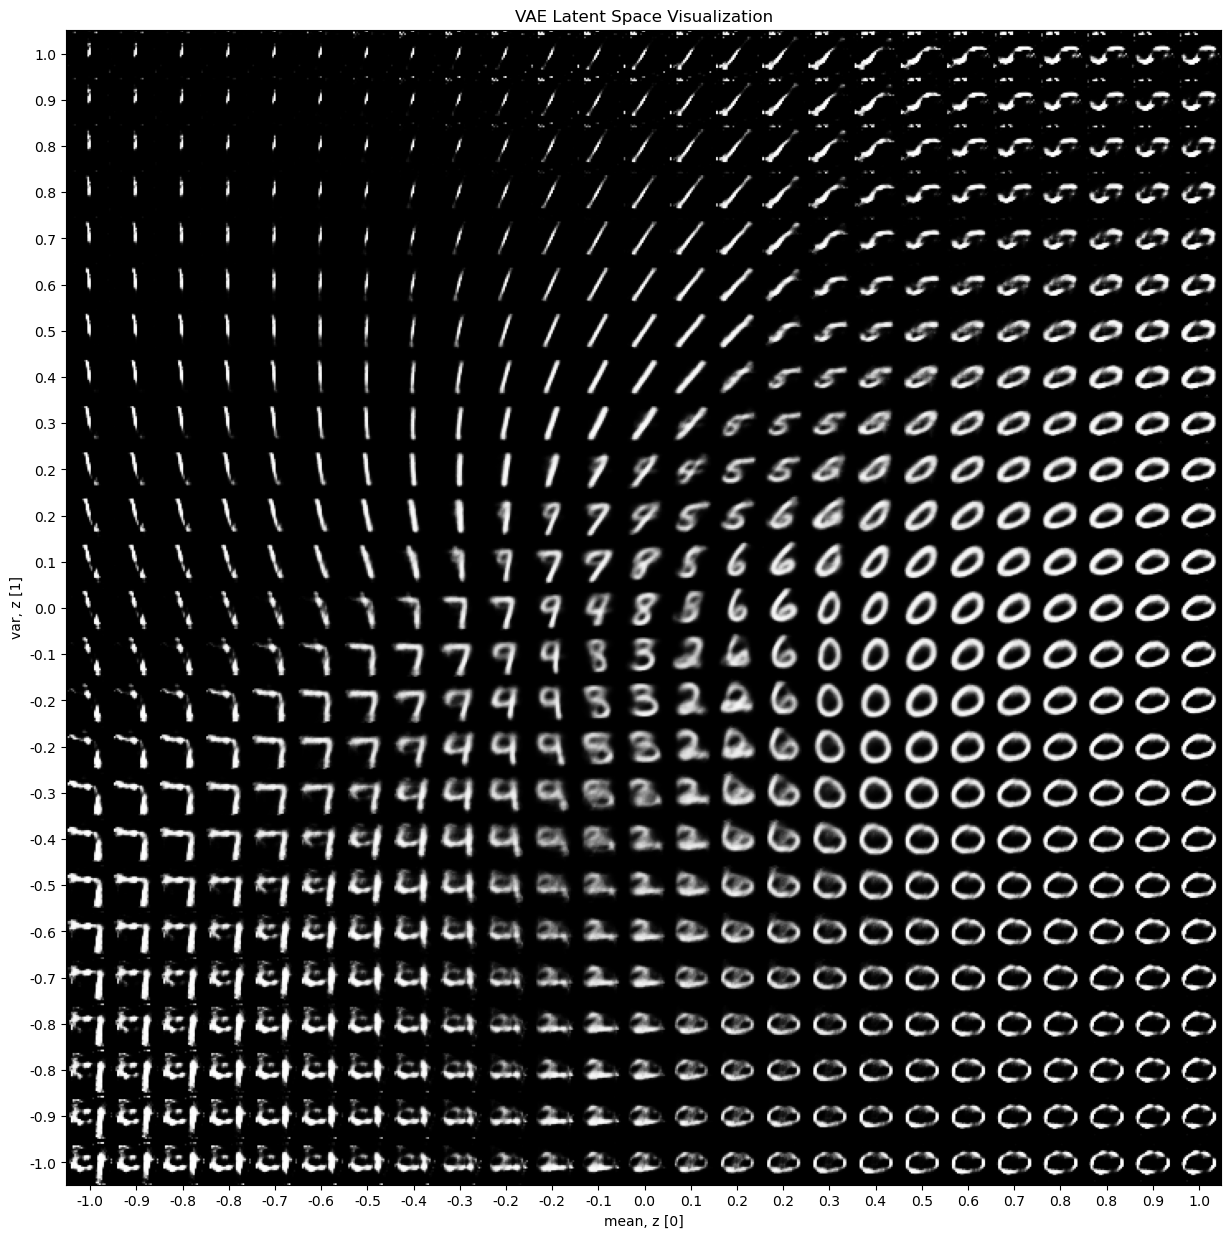

In [7]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model, scale=1.)

In [8]:
print(train_dataset.targets.bincount())

tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])
